### Imports

## Set up Colab

In [1]:
!/opt/bin/nvidia-smi
!pip install tensorflow-gpu==1.15.0

/bin/bash: /opt/bin/nvidia-smi: No such file or directory


## Mount your drive

In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


## Change directory to the script

In [3]:
import os
path = "/content/drive/My Drive/RNN_workingmemoryaccuracy"#example:"/content/drive/My Drive/RNN_workingmemoryaccuracy"
os.chdir(path)
!pwd

/content/drive/.shortcut-targets-by-id/1Gh6ygWw120eiPxogvBZStQ-BCV_5mBnd/RNN_workingmemoryaccuracy


In [4]:
!ls /content/drive/MyDrive/RNN_workingmemoryaccuracy

analysis
Averaged_R_tuning_locs.py
data
endpoint_analysis.py
figure
input_weight_distribution.py
Main_analysis.ipynb
Main_training.py
neuron_heatmap.py
plot_psth.py
__pycache__
R_distribution_dev_saccade_dev_fr.py
single_neuron_fano_factor.py
single_neuron_PSTH.py
task_and_network
training
utils
weight_matrix_best_location.py
weight_matrix_distribution_cluster_all_3s_fix_in_own_scale.pdf


In [5]:
import numpy as np
from numpy import *
from matplotlib import pyplot as plt
import matplotlib as mpl
import sys
sys.path.append('.')
from utils import tools
from scipy.stats.stats import pearsonr
from utils.tools import mkdir_p,auto_model_select,smooth
import statistics
from utils.functions import gen_task_info, split_trials, select_H_by_trialidx, select_neurons_excitatory
import warnings

warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [6]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

### GPU set up

### Load model directory

In [7]:
model_dir = 'data/6tasks_8loc_256neuron_odr3000_seed0'

### Load model saved infomation

In [8]:
hp = tools.load_hp(model_dir)
log = tools.load_log(model_dir)

### Model parameters

In [9]:
stage = 'mature'
rule = 'odr3000'
epoch = 'delay1' # delay period

In [10]:
# prepare task info
task_info = gen_task_info(hp,model_dir,[rule])

Epoch information:
	odr3000:
		fix1: (None, 50)
		stim1: (50, 75)
		delay1: (75, 225)
		go1: (225, None)


In [11]:
# select one model and compute model performance
model_select_odr3000 = {'mature':748800,'mid':710400,'early':604160}
models_select = model_select_odr3000
model_idx = log['trials'].index(models_select[stage])
model_perf = log['perf_' + rule][model_idx]

In [14]:
# find correct trials and split them into clockwise and counterclockwise trials
all_H, correct_idx, correct_cw_idx, correct_ccw_idx, all_stage_keys, all_in_loc_info, dev_theta = split_trials(hp,log, model_dir, rule, [models_select[stage]], task_info, trial=None, task_mode='test')

In [15]:
# correct trials firing rate matrix (Time, Batch, Unit) and location information
correct_H = select_H_by_trialidx(all_H,correct_idx)
correct_loc_info = np.array(all_in_loc_info)[correct_idx]

In [16]:
# Neurons selection
significant_neuron_all = np.arange(hp['n_rnn'])
print('# all_significant_neuron = ', len(significant_neuron_all))
significant_neuron_delay = select_neurons_excitatory(hp, rule, task_info, epoch, correct_H, correct_loc_info)
print('# delay_significant_neuron = ', len(significant_neuron_delay))

# all_significant_neuron =  256
# delay_significant_neuron =  114


### Averaged R of 8 locations

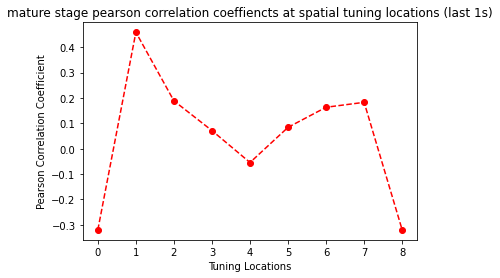

In [17]:
from Averaged_R_tuning_locs import plot_R_last
time_50 = 50 
plot_R_last(correct_idx, correct_cw_idx, correct_ccw_idx, epoch, rule, correct_H, correct_loc_info,
                            task_info, significant_neuron_delay, dev_theta,model_perf,stage,'delay_neurons',time_50)

### Fano factor

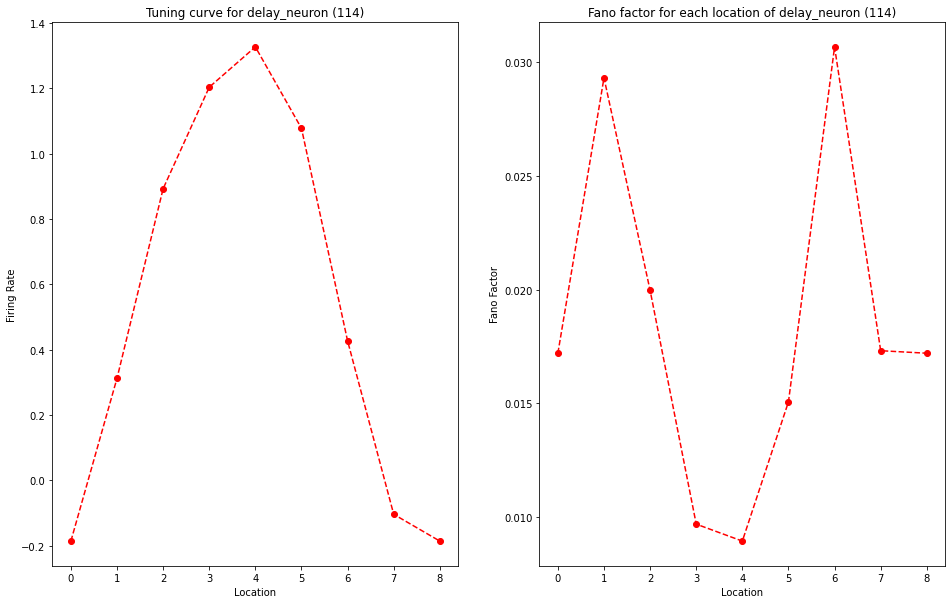

In [18]:
from single_neuron_fano_factor import plot_fano_tuning_average_last
time_50 = 50
plot_fano_tuning_average_last(correct_H, correct_loc_info, significant_neuron_delay, rule, epoch, task_info,
                                      model_perf, stage, 'delay_neuron', time_50)


### Pearson correlation coefficients mean of saccade deviation vs theta deviation

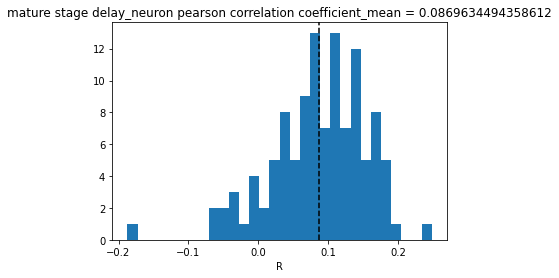

In [19]:
from R_distribution_dev_saccade_dev_fr import R_distribute_last
time_50 = 50
R_distribute_last(correct_idx,correct_cw_idx, correct_ccw_idx, epoch, rule, correct_H, correct_loc_info,
                    task_info, significant_neuron_delay,dev_theta,model_perf,'delay_neuron',time_50,stage)

### Endpoint analysis of correct and error trials 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


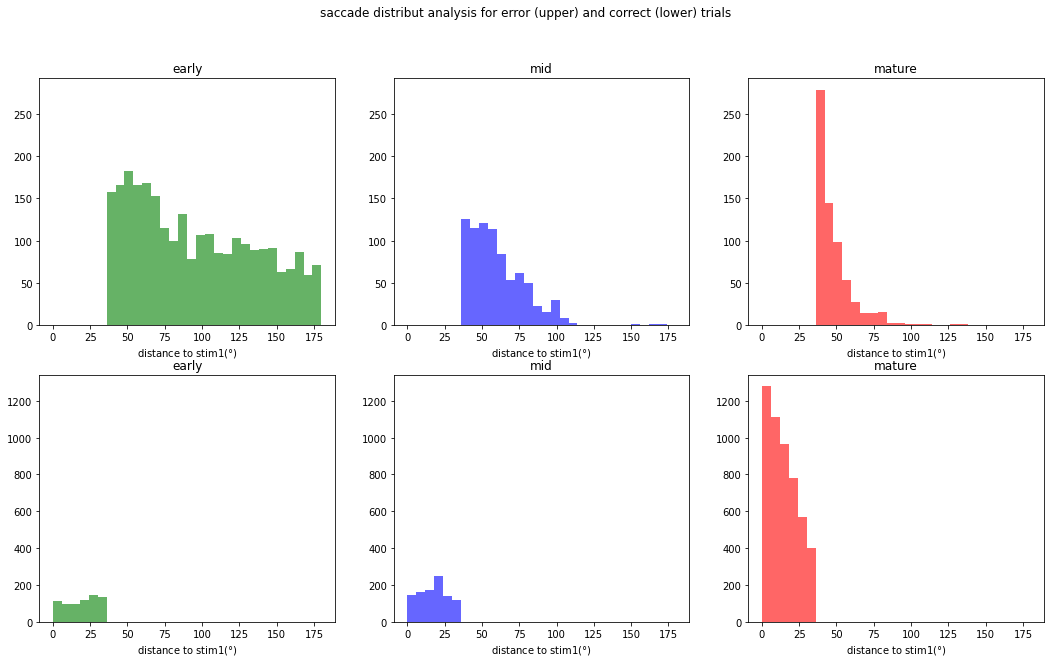

In [20]:
from endpoint_analysis import saccade_distribut_analysis, combined_trial_range
from analysis.PSTH_print_basic_info import print_basic_info

trial_range = print_basic_info(hp, log, model_dir, smooth_growth=True, smooth_window=5, auto_range_select=True)
saccade_distribut_analysis(hp, log, rule, model_dir, trial_list=combined_trial_range(trial_range, rule), )

### Single neuron raster plot

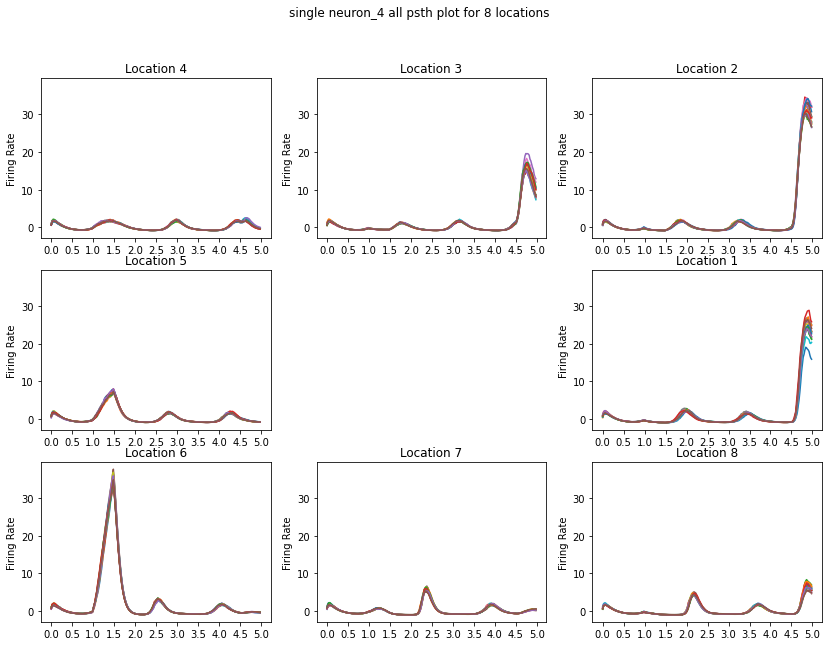

In [21]:
from single_neuron_PSTH import gen_single_neuron_PSTH_
gen_single_neuron_PSTH_(hp, rule, correct_H, correct_loc_info, stage, model_perf,task_info,model_dir)

### Plot PSTH of ODR and ODRD

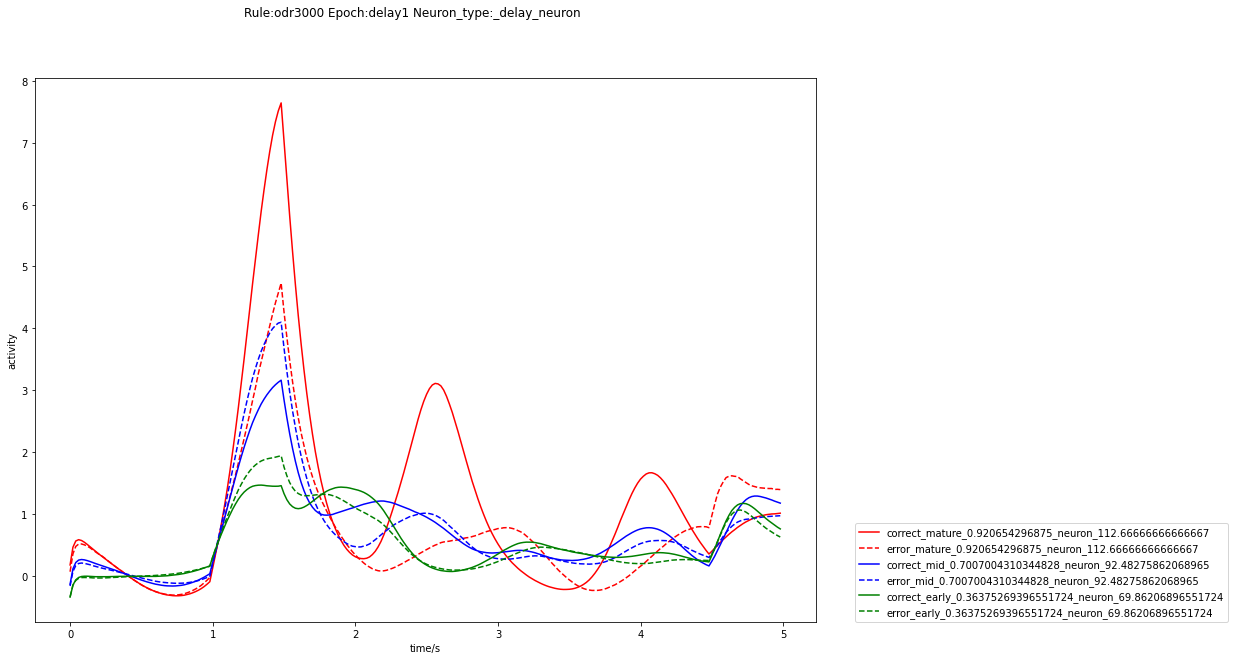

In [22]:
from plot_psth import plot_multiple_model_psth
model_select = auto_model_select(hp, log, smooth_window=9, perf_margin=0.05, max_model_num_limit=30)
# ODR task with normalized firing rate for delay neurons
plot_multiple_model_psth(hp, log, model_dir, rule, epoch, model_select[rule], task_info,'delay_neuron', plot_oppo_dir=False,norm=True, )

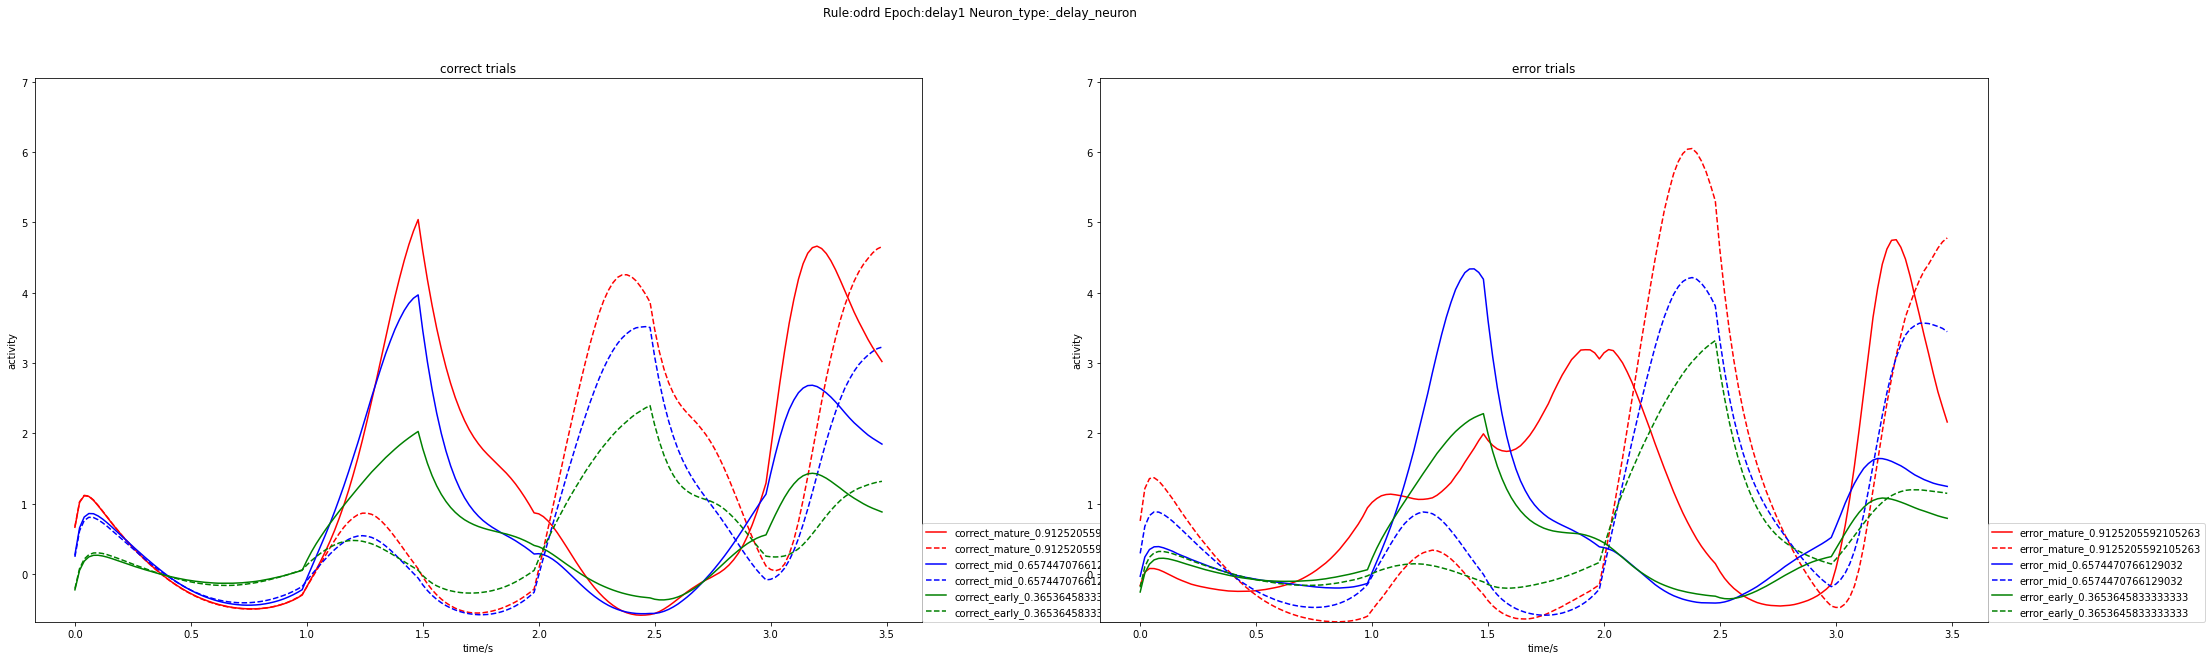

In [23]:
# ODRD task with normalized firing rate for delay neurons
plot_multiple_model_psth(hp, log, model_dir, 'odrd', epoch, model_select['odrd'], task_info, 'delay_neuron', plot_oppo_dir=True,
                         norm=True, )

### Weight matrix

[0.465, 0.465, 0.3025, 0.3025]


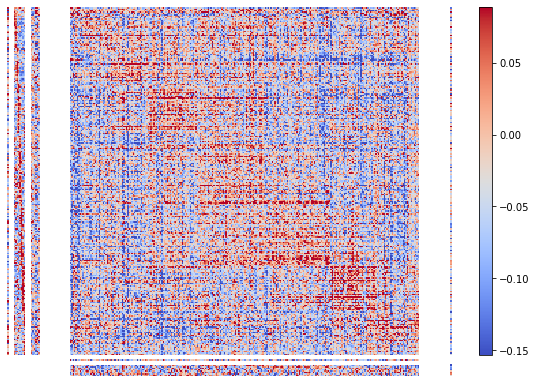

In [24]:
from weight_matrix_best_location import find_best_epoch_location,synaptic_analysis
epoch = 'stim1'
norm = True
best_cue_neuron_info = find_best_epoch_location(rule, epoch, task_info, correct_H, correct_loc_info,
                                                    significant_neuron_all, norm=norm)
best_loc = []
for each_info in best_cue_neuron_info:
        best_loc.append(each_info[1])
synaptic_analysis(hp, model_dir, models_select[stage], best_loc,cluster_analysis=True, cluster_type="rule", rules=None)

### Input weights distribution

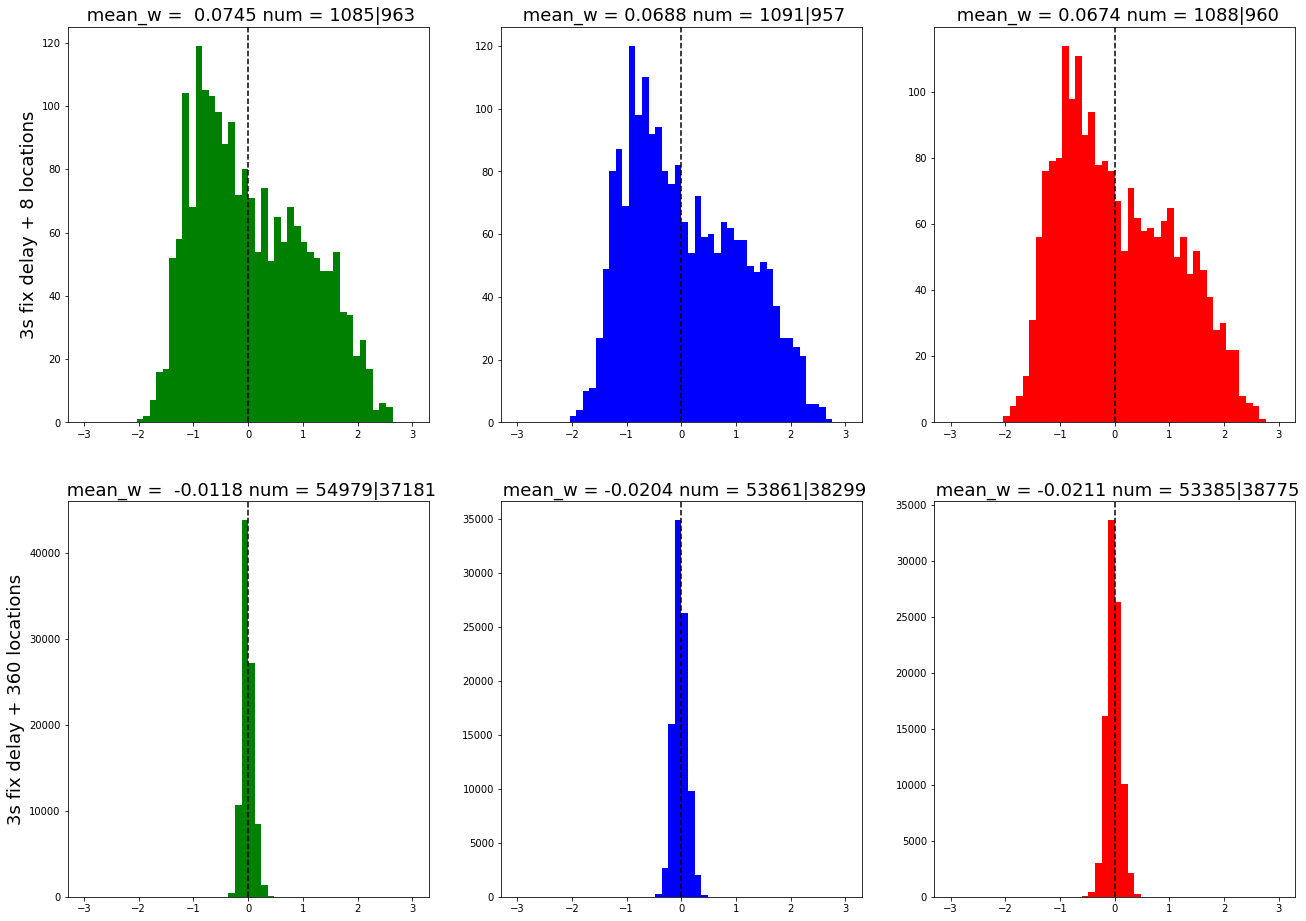

In [25]:
from input_weight_distribution import plot_distribution
plot_distribution()

## Heatmap for 360 locations and 256 units

### model parameters

In [26]:
model_dir_h = 'data/6tasks_360loc_256neuron'
hp_h = tools.load_hp(model_dir_h)
log_h = tools.load_log(model_dir_h)
# model parameters
stage_h = 'mid'
rule_h = 'odr'
norm_h = True

### prepare task info

In [27]:
task_info_h = gen_task_info(hp_h,model_dir_h,[rule_h])

Epoch information:
	odr:
		fix1: (None, 50)
		stim1: (50, 75)
		delay1: (75, 150)
		go1: (150, None)


### select one model

In [ ]:
models_select_h = {'mature': 153600, 'mid': 70400, 'early':49920 }
model_idx_h = log_h['trials'].index(models_select_h[stage_h])
model_perf_h = log_h['perf_'+rule_h][model_idx_h]

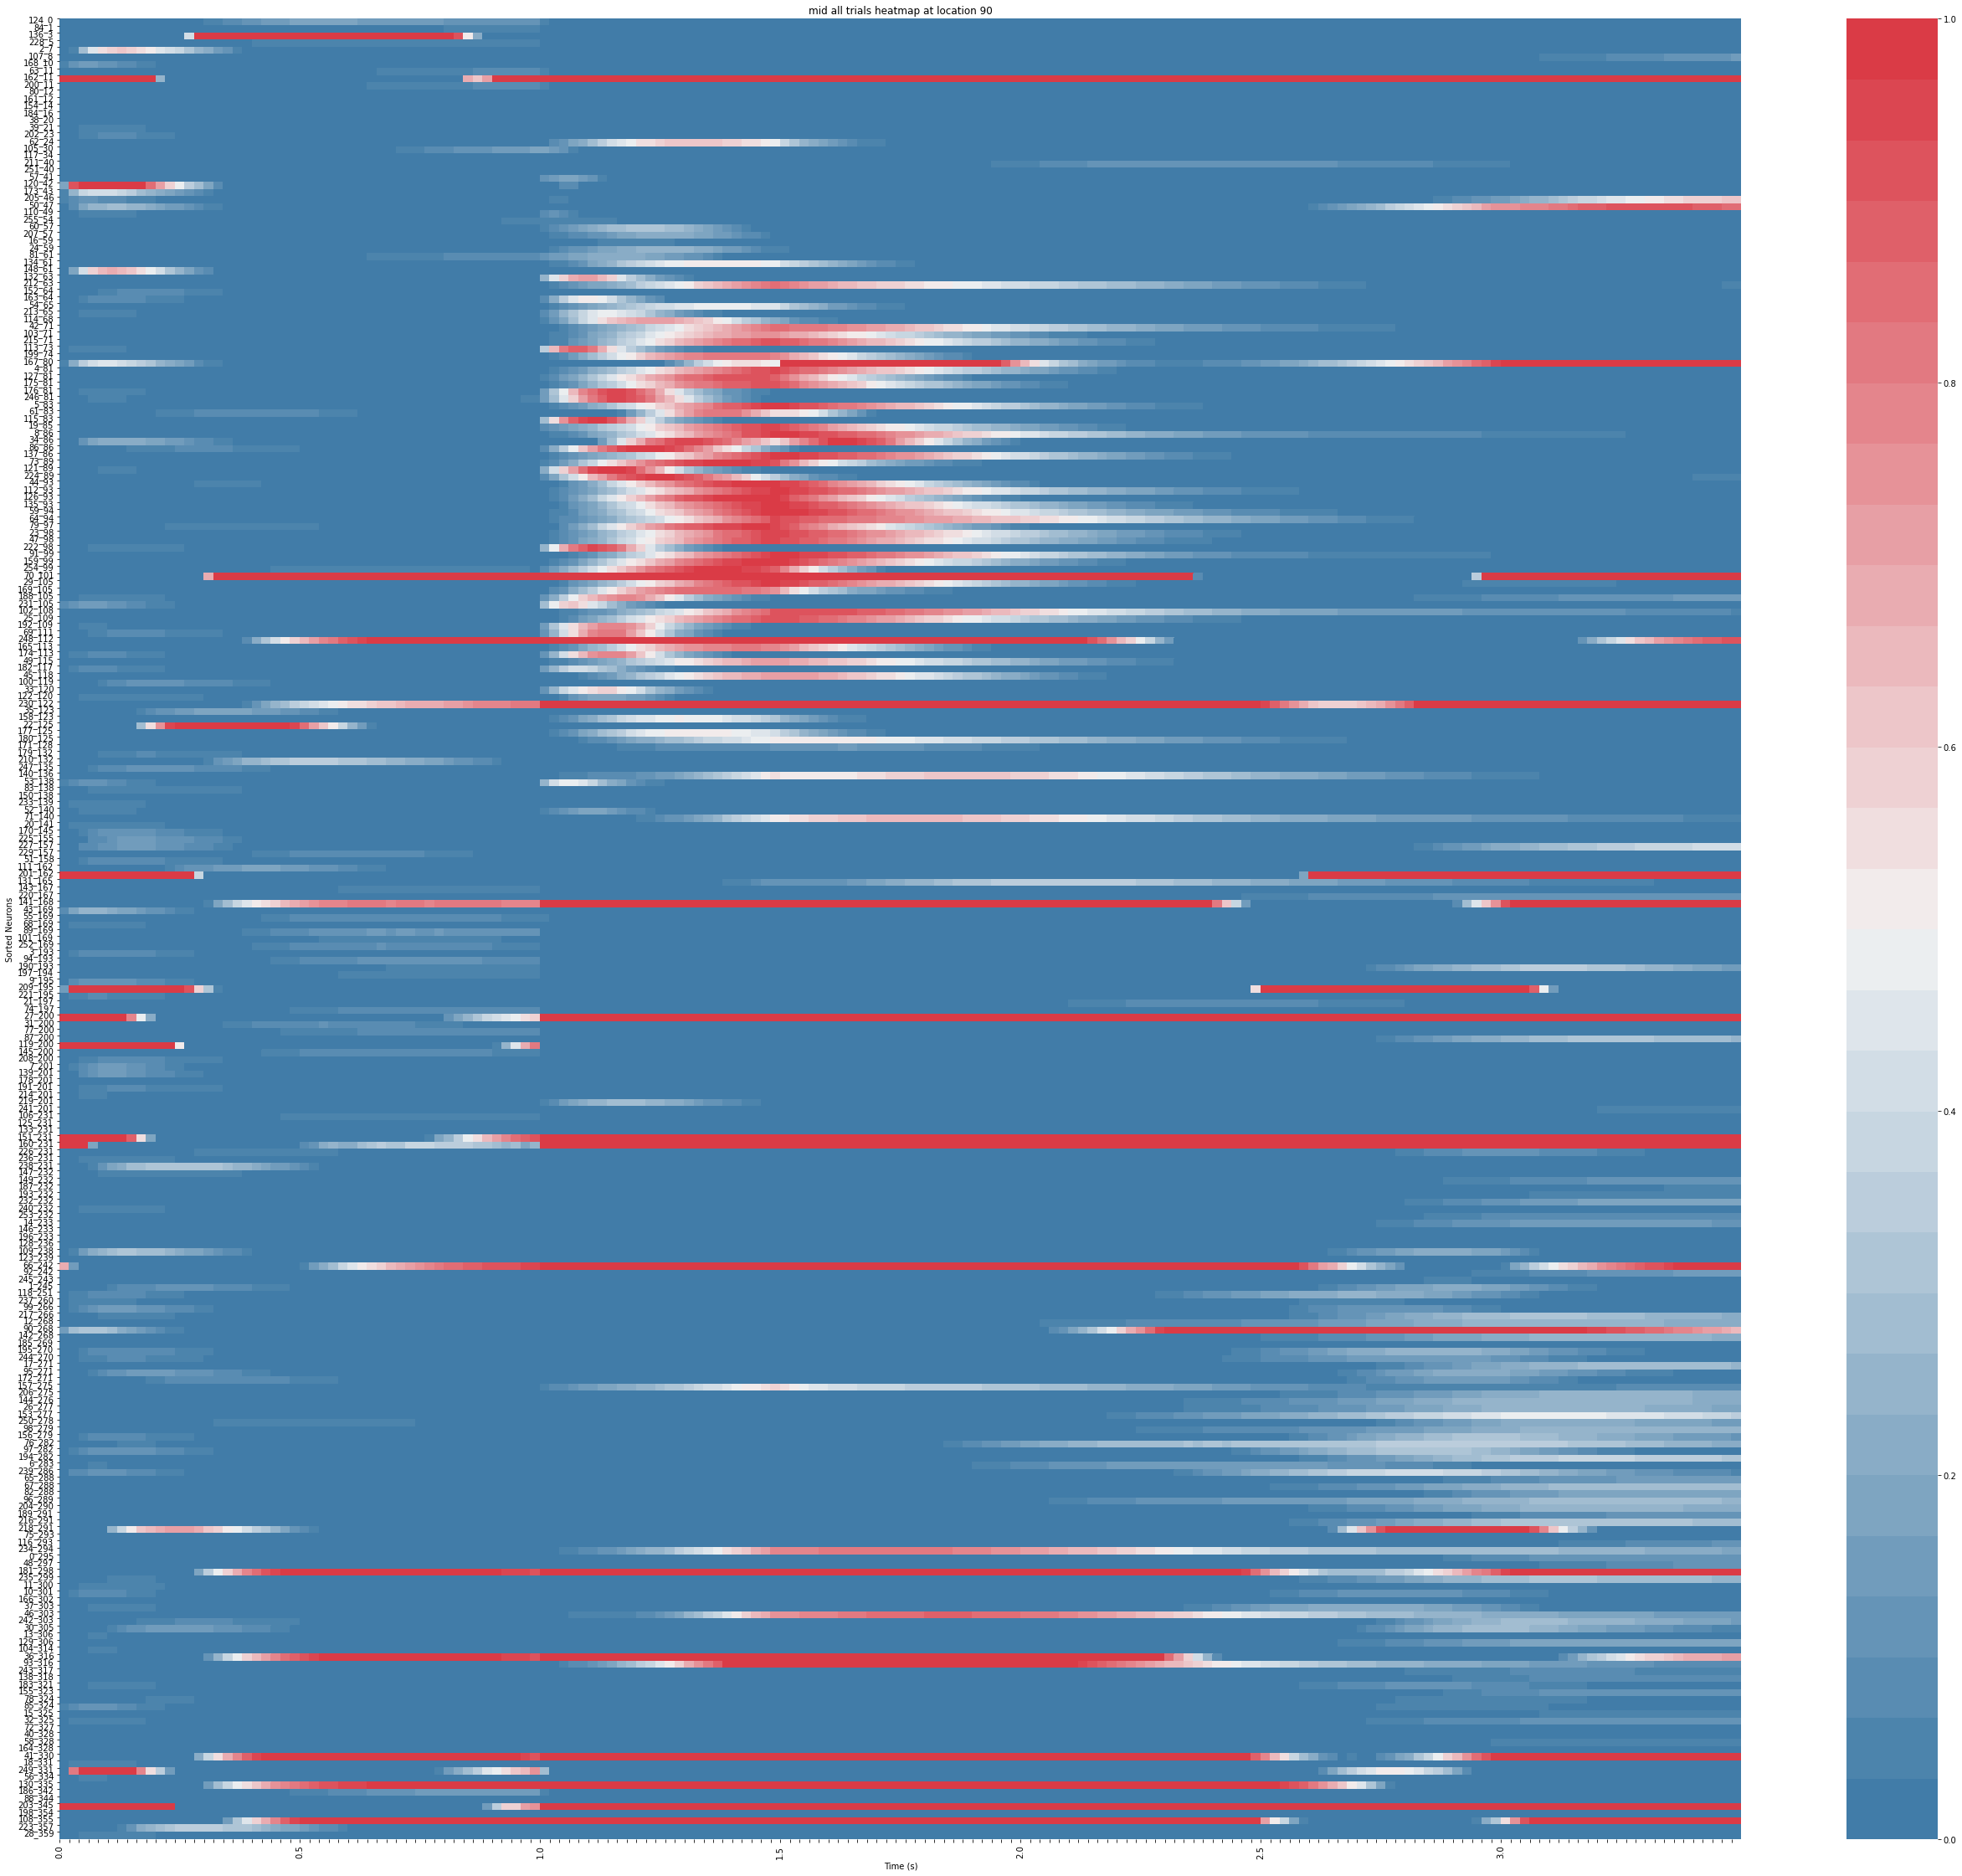

In [ ]:
from neuron_heatmap import gen_multiple_trials_heatmap,find_best_epoch_location

all_H_h, correct_idx_h, correct_cw_idx_h, correct_ccw_idx_h, all_stage_keys, all_in_loc_info_h, dev_theta = split_trials(hp_h,log_h, model_dir_h, rule_h, [models_select_h[stage_h]], task_info_h, trial=None, task_mode='test')
# select all neurons
significant_neuron_all = np.arange(hp_h['n_rnn'])
# print('# all_significant_neuron = ', len(significant_neuron_all))
significant_neuron = significant_neuron_all
correct_H_h = select_H_by_trialidx(all_H_h,correct_idx_h)
correct_loc_info_h = np.array(all_in_loc_info_h)[correct_idx_h]
best_cue_neuron_info_h = find_best_epoch_location(rule_h,'stim1',task_info_h,correct_H_h,correct_loc_info_h,significant_neuron_all,norm=norm_h)
# plot heatmap with neurons sorted by best cue location
loc_num = 90
gen_multiple_trials_heatmap(rule_h, 'stim1', task_info_h, all_H_h, correct_cw_idx_h,correct_ccw_idx_h, stage_h, best_cue_neuron_info_h, model_dir_h, loc_num,model_perf_h,norm=norm_h)
